### Test of generating alternating single qubit and two qubit layers

In [2]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from utils.layers import alternating_sq_2q_layers

c:\Users\c5517\python\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


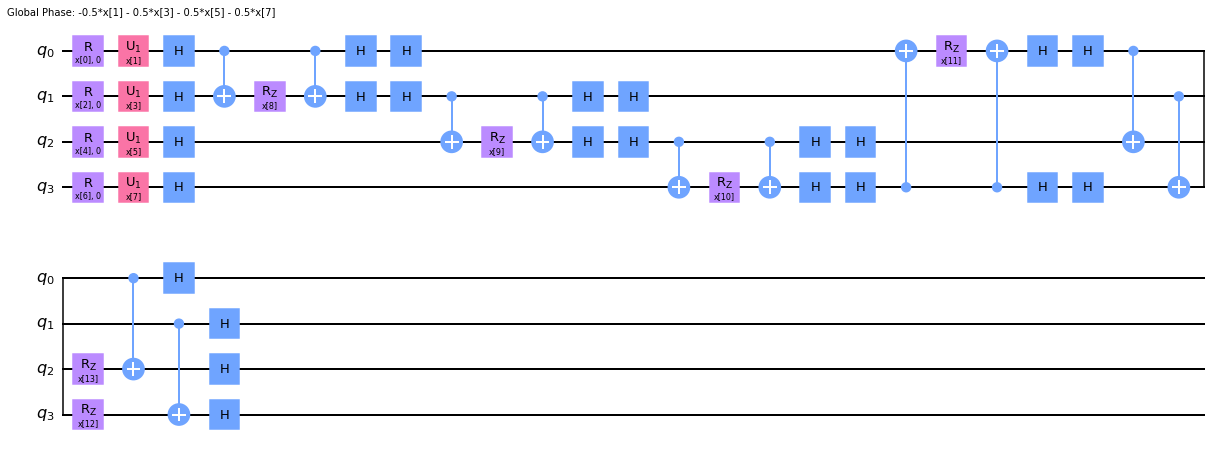

In [3]:
connectivity = [[0,1], [1,2], [2,3],[3,0], [1,3], [0,2]]
circ = alternating_sq_2q_layers(4,1,'RXX', connectivity)
circ.decompose().draw('mpl')
# circ.draw('mpl')

In [4]:
# qasm convert
print(qiskit.qasm2.dumps(circ.assign_parameters(np.ones(14))))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
rx(1.0) q[0];
rz(1.0) q[0];
rx(1.0) q[1];
rz(1.0) q[1];
rx(1.0) q[2];
rz(1.0) q[2];
rx(1.0) q[3];
rz(1.0) q[3];
rxx(1.0) q[0],q[1];
rxx(1.0) q[1],q[2];
rxx(1.0) q[2],q[3];
rxx(1.0) q[3],q[0];
rxx(1.0) q[1],q[3];
rxx(1.0) q[0],q[2];


In [32]:
from qiskit_algorithms.optimizers import L_BFGS_B, COBYLA
from qiskit_aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
import qiskit.quantum_info as qi

intermediate_cost = []
intermediate_params = []

def cost(params, target):
    '''
    target: dict
            count_dictionary obtained from the probe circuit
    params: 
    '''
    connectivity = [[0,1], [1,2], [2,3],[3,0], [1,3], [0,2]]
    circ = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(params)
    result_dict = qi.Statevector.from_instruction(circ).probabilities_dict()
    cost = 0
    for (key1, value1), (key2, value2) in zip(target.items(), result_dict.items()):
        cost += (value1-value2)**2 
    
    intermediate_cost.append(cost)
    intermediate_params.append(params)
    return cost

def callback_func(params, target):
    cost_value = cost(params, target)  # Calculate the cost at the current iteration
    intermediate_cost.append(cost_value)
    intermediate_params.append(params)

In [33]:
import torch
import torch.optim as optim
import qiskit.quantum_info as qi

params = np.ones(14)
circ = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(params)
target = qi.Statevector.from_instruction(circ).probabilities_dict()
target

{'0000': 0.12617565065018493,
 '0001': 0.005809569833027938,
 '0010': 0.0058095698330279345,
 '0011': 0.021492938817427427,
 '0100': 0.005809569833027941,
 '0101': 0.021492938817427427,
 '0110': 0.02149293881742741,
 '0111': 0.10853778902716256,
 '1000': 0.005809569833027945,
 '1001': 0.021492938817427427,
 '1010': 0.021492938817427445,
 '1011': 0.10853778902716252,
 '1100': 0.021492938817427445,
 '1101': 0.10853778902716256,
 '1110': 0.10853778902716252,
 '1111': 0.2874772810044898}

In [34]:
from scipy.optimize import minimize
parameters = [np.random.random() for _ in range(14)]
out = minimize(cost, x0=parameters, args = target ,method="L-BFGS-B", options={'maxiter':100})
cost(out.jac,target)

0.8962406700285894

In [28]:
out.jac

array([ 3.71586046e-06,  1.63926306e-06,  1.24341436e-06, -2.84061336e-07,
        4.41157441e-06, -4.59482572e-06, -1.03750547e-06, -2.38620122e-06,
        8.96260395e-07,  4.28479327e-07, -3.04017037e-07, -3.34260884e-06,
       -2.84835160e-06, -3.61765128e-07])

In [36]:
cost(intermediate_params[50],target)

0.0023573630699276964

In [37]:
check = alternating_sq_2q_layers(4,1,'RXX', connectivity, measurement=False).assign_parameters(intermediate_params[50])
check_result = qi.Statevector.from_instruction(check).probabilities_dict()
check_result

{'0000': 0.11882114819375582,
 '0001': 0.007057854532394809,
 '0010': 0.0003700834041133225,
 '0011': 0.010301819940880499,
 '0100': 0.0071836715565679376,
 '0101': 0.02788283460899076,
 '0110': 0.020099063612148627,
 '0111': 0.12323762360073867,
 '1000': 0.002251321492415692,
 '1001': 0.010556205408241247,
 '1010': 0.03294470843543727,
 '1011': 0.13363527161249408,
 '1100': 0.0018094141059110378,
 '1101': 0.0963810949637856,
 '1110': 0.12826473701965893,
 '1111': 0.27920314751246617}

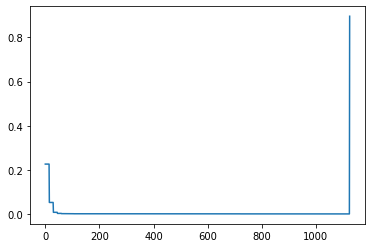

In [35]:
import matplotlib.pyplot as plt
plt.plot(intermediate_cost)